In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import copy

/opt/conda/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
results_cats = ["baron", "seger", "xin"]

combs = [sorted(list(ls)) for ls in list(itertools.combinations(results_cats,2))]
combs

[['baron', 'seger'], ['baron', 'xin'], ['seger', 'xin']]

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 
# ignores FutureWarnings. Helps in readbility.
# Since we are using a conda envrionment with defined package versions we are not concerned with changes in a package's future releases.


In [4]:
datadir = "data"
savedir = "plots"

if not os.path.exists(savedir):
    os.mkdir(savedir)

In [5]:
jsds_glob_dict = {}
jsds_glob_means_dict = {}
jsds_glob_stds_dict = {}

for comb in combs:
    cat0, cat1 = comb[0], comb[1]
    methods = ["MuSiC", "CibersortX", "Scaden", "TAPE-O", "TAPE-A", "BayesPrism", "BayesPrism-M", "DISSECT"]
    
    results = [os.path.join(datadir, "{}_{}.csv").format(method.replace(" ", "_"), cat0) for method in methods]
    results_dict = dict(zip(methods, results))
    
    results = [os.path.join(datadir, "{}_{}.csv").format(method.replace(" ", "_"), cat1) for method in methods]
    results_dict1 = dict(zip(methods, results))
    
    df_results_dict = {}

    for method in results_dict.keys():
        if "MuSiC" in method:
            df = pd.read_csv(results_dict[method], index_col=0)
        else:
            df = pd.read_table(results_dict[method], index_col=0)
            if "CibersortX" in method:
                df = df.iloc[:,:-3]
        # df[df<0] = 0
        df_results_dict[method] = df
        
    df_results_dict1 = {}

    for method in results_dict1.keys():
        if "MuSiC" in method:
            df = pd.read_csv(results_dict1[method], index_col=0)
        else:
            df = pd.read_table(results_dict1[method], index_col=0)
            if "CibersortX" in method:
                df = df.iloc[:,:-3]

        df_results_dict1[method] = df
        
    common = list(set(df_results_dict["MuSiC"].columns)&set(df_results_dict1["MuSiC"].columns))
    
    from scipy.spatial.distance import jensenshannon as jsd

    jsds_dict = {}
    jsds_means_dict = {}
    jsds_stds_dict = {}
    for method in methods:
        x = df_results_dict[method][common]
        x = x.div(x.sum(1),0)
        y = df_results_dict1[method][common]
        y = y.div(x.sum(1),0)

        jsds_ls = []
        for i in range(x.shape[0]):
            jsds_ls.append(jsd(x.iloc[i,:], y.iloc[i,:]))

        jsds_dict[method] = jsds_ls
        jsds_means_dict[method] = np.mean(jsds_ls)
        jsds_stds_dict[method] = np.std(jsds_ls)
        
    jsds_glob_dict["_".join(comb)] = copy.deepcopy(jsds_dict)
    jsds_glob_means_dict["_".join(comb)] = copy.deepcopy(jsds_means_dict)
    jsds_glob_stds_dict["_".join(comb)] = copy.deepcopy(jsds_stds_dict)

In [6]:
pal=sns.color_palette("colorblind", len(methods)+1) # 1 for linear MLPs
pal_hex = pal.as_hex()

In [7]:
pal

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2)]

In [8]:
print(pal_hex)

['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4', '#949494', '#ece133']


In [9]:
# store above list in colors
colors = ['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4', '#949494', '#ece133']


In [10]:
colors_dict = {}
i=0
methods1 = ["MuSiC", "CibersortX", "Scaden", "TAPE-O", "TAPE-A", "Linear MLPs", "BayesPrism", "BayesPrism-M", "DISSECT"]
for method in methods1:
    colors_dict[method] = colors[i]
    i+=1

In [11]:
sns.set(style="whitegrid", font_scale=1.3)

In [12]:
keys = list(jsds_glob_dict.keys())
i=0
for key in keys:
    keys_ = list(jsds_glob_dict[key].keys())
    for key_ in keys_:
        if i==0:
            df = pd.DataFrame(jsds_glob_dict[key][key_], columns=["estimate"])
            # df.columns=[key_]
            df["data"] = [key]*df.shape[0]
            df["method"] = [key_]*df.shape[0]
            # print(df)
            i+=1
        else:
            tmp = pd.DataFrame(jsds_glob_dict[key][key_], columns=["estimate"])
            # tmp.columns=[key_]
            tmp["data"] = [key]*tmp.shape[0]
            tmp["method"] = [key_]*tmp.shape[0]
            # print(tmp)
            df = pd.concat([df, tmp], axis=0)


In [13]:
df

,estimate,data,method
0,0.227191,baron_seger,MuSiC
1,0.202829,baron_seger,MuSiC
2,0.262270,baron_seger,MuSiC
3,0.275371,baron_seger,MuSiC
4,0.289348,baron_seger,MuSiC
...,...,...,...
84,0.138025,seger_xin,DISSECT
85,0.156983,seger_xin,DISSECT
86,0.175389,seger_xin,DISSECT
87,0.156168,seger_xin,DISSECT


In [14]:
color_palette = {'MuSiC': '#0173b2',
                 'CibersortX': '#de8f05',
                 'Scaden': '#029e73',
                 'TAPE-O': '#d55e00',
                 'TAPE-A': '#cc78bc',
                 'Linear MLPs': '#ca9161',
                 'BayesPrism': '#ece133',
                 'BayesPrism-M': '#949494',
                 'DISSECT': '#fbafe4'} # same colors as in main

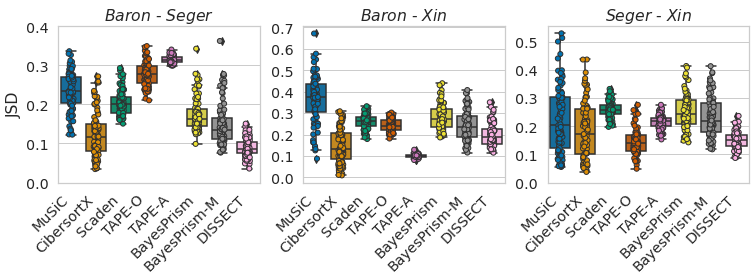

In [16]:
i=1
plt.figure(figsize=(14,4))
for comb in combs:
    indices = list(range(len(jsds_glob_dict["_".join(comb)]["MuSiC"])))
    pd.DataFrame.iteritems = pd.DataFrame.items
    df = pd.DataFrame(index=indices, columns=methods)
    for method in methods:
        df[method] = jsds_glob_dict["_".join(comb)][method]

    ax = plt.subplot(1,4,i)
    sns.boxplot(data=df, palette=color_palette, ax=ax)
    sns.stripplot(data=df, palette=color_palette, ax=ax, edgecolor="gray",
                 linewidth=1)
    plt.xticks(rotation=45, ha="right")
    if i==1:
        plt.ylabel("JSD")
    i+=1
    range_ = np.arange(0, df.max().max()+0.05, 0.1)
    plt.yticks(range_)
    plt.title(r"${}$".format(comb[0].capitalize()) + " - " + r"${}$".format(comb[1].capitalize()))
    
for comb in combs:
    indices = list(range(len(jsds_glob_dict["_".join(comb)]["MuSiC"])))
    tmp = pd.DataFrame(index=indices, columns=methods)
    for method in methods:
        tmp[method] = jsds_glob_dict["_".join(comb)][method]

    tmp["comb"] = "_".join(comb)
    if comb==combs[0]:
        df=tmp.copy()
    else:
        df=pd.concat([df, tmp], axis=0)

plt.tight_layout()

plt.savefig(os.path.join(savedir, "S4A_jsd_pancreas_reformat.pdf"), bbox_inches="tight")
plt.savefig(os.path.join(savedir, "S4A_jsd_pancreas_reformat.png"), bbox_inches="tight", dpi=300)

# hb1ac

In [17]:
df_metadata = pd.read_table(os.path.join(datadir, "metadata_pancreas.txt"), index_col=0)
df_metadata = df_metadata.dropna()

In [18]:
import matplotlib.ticker as ticker

In [19]:
methods = ["MuSiC", "CibersortX", "Scaden", "TAPE-O", "TAPE-A", "Linear MLPs", "BayesPrism", "BayesPrism-M", "DISSECT"]

df_dict = {}
for cat in results_cats:
    df_dict[cat] = {}
    results = [os.path.join(datadir, "{}_{}.csv".format(method.replace(" ", "_"), cat)) for method in methods]
    results_dict = dict(zip(methods, results))
    
    for method in methods:
        if "MuSiC" in method:
            df = pd.read_csv(results_dict[method], index_col=0)
        else:
            df = pd.read_table(results_dict[method], index_col=0)
            if "CibersortX" in method:
                df = df.iloc[:,:-3]
        # df[df<0] = 0
        df_dict[cat][method] = df

In [20]:
sns.set(style="whitegrid", font_scale=1.3)

In [21]:
color_palette

{'MuSiC': '#0173b2',
 'CibersortX': '#de8f05',
 'Scaden': '#029e73',
 'TAPE-O': '#d55e00',
 'TAPE-A': '#cc78bc',
 'Linear MLPs': '#ca9161',
 'BayesPrism': '#ece133',
 'BayesPrism-M': '#949494',
 'DISSECT': '#fbafe4'}

In [22]:
from decimal import Decimal

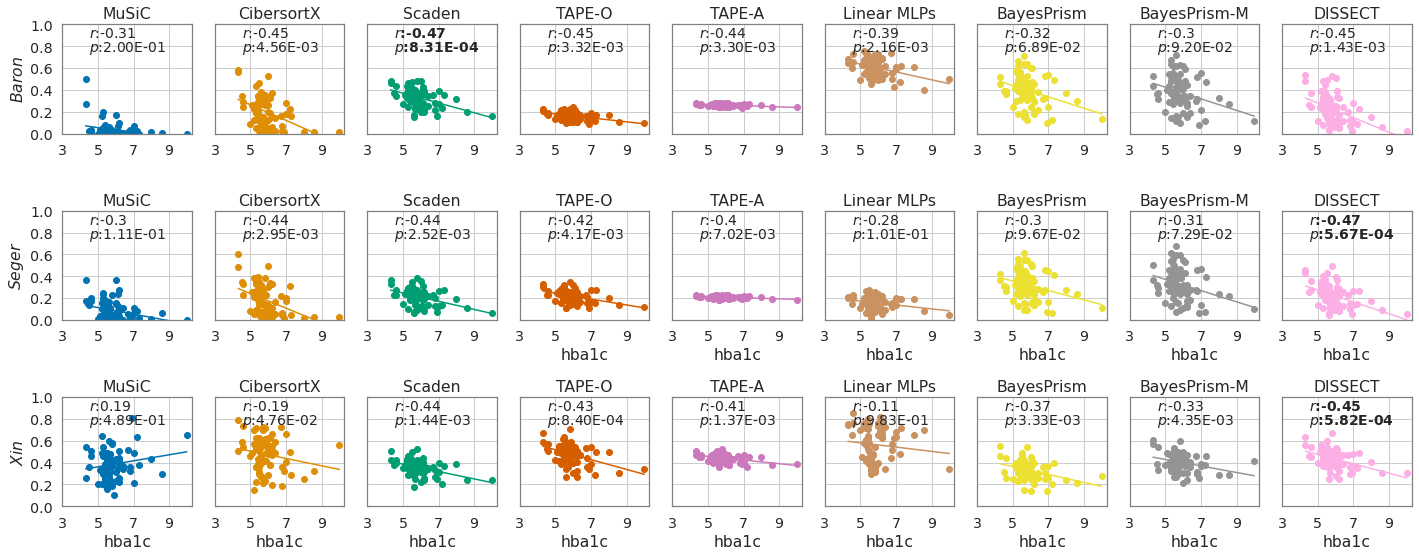

In [23]:
methods = list(df_dict["baron"].keys())
datasets = list(df_dict.keys())
tick_spacing = .5

import statsmodels.api as sm
from scipy import stats
plt.figure(figsize=(20,8))
i=1
for dataset in datasets:
    for method in methods1:

        ax=plt.subplot(3,len(methods1),i)
        
        y = df_dict[dataset][method].loc[df_metadata.index.tolist(), "beta"]
        x = df_metadata["hba1c"]
        
        corr = np.corrcoef(x,y)[0,1]
        x1= df_dict[dataset][method]["beta"][df_metadata.index.tolist()]
        x2=df_metadata[["gender"]]
        x3=df_metadata[["age"]]
        x4=df_metadata[["bmi"]]

        X = pd.concat([x1, x2, x3, x4], axis=1)
        z = df_metadata["hba1c"]

        X["Const"] = [1.0]*X.shape[0]

        X["sex"] = np.ones((X.shape[0],))
        X.loc[X.gender=="Male", "sex"] = 0

        X = X[["beta", "age", "Const", "bmi", "sex"]]

        est = sm.OLS(z, X)
        est1 = est.fit()
        pval = est1.pvalues["beta"]
        
        plt.scatter(x, y, color=color_palette[method])
        plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),
                color=color_palette[method])
        plt.ylim(0,1)
        
        
        plt.xticks(np.arange(3, 10.01, 2))
        plt.title(method)
        
        if method=="DISSECT" and dataset!="baron":
            plt.text(4.5, 0.88, r"$r$:" + str(round(corr, 2)), fontsize=14, weight="bold")
            plt.text(4.5, 0.75, r"$p$:" + "%.2E"%Decimal(pval), fontsize=14, weight="bold")
        elif method=="Scaden" and dataset=="baron":
            plt.text(4.5, 0.88, r"$r$:" + str(round(corr, 2)), fontsize=14, weight="bold")
            plt.text(4.5, 0.75, r"$p$:" + "%.2E"%Decimal(pval), fontsize=14, weight="bold")
        else:
            plt.text(4.5, 0.88, r"$r$:" + str(round(corr, 2)), fontsize=14)
            plt.text(4.5, 0.75, r"$p$:" + "%.2E"%Decimal(pval), fontsize=14)
        plt.yticks(np.arange(0, 1.01, 0.2))
        if i in [1,10,19]:
            plt.ylabel(r"${}$".format(dataset.capitalize()))
            
        else:
            ax.set_yticklabels([])
        i+=1
            
        if i >=14:
            plt.xlabel("hba1c")


        ax.spines['bottom'].set_color('gray')
        ax.spines['top'].set_color('gray') 
        ax.spines['right'].set_color('gray')
        ax.spines['left'].set_color('gray')
        
plt.tight_layout()
plt.savefig(os.path.join(savedir, "S4B_scatter_beta_reformat.pdf"), bbox_inches="tight")
plt.savefig(os.path.join(savedir, "S4B_scatter_beta_reformat.png"), bbox_inches="tight", dpi=300)
plt.show()